# DNN from Scratch

Deep learning applications have been tremendously facilitated by various open-source libraries such as [TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), [scikit-learn](https://scikit-learn.org/stable/) and [Apache Spark](https://spark.apache.org/). To fully understand what happens inside the black box, however, the best practice is to code from scratch. 

In this notebook, we will hand code a deep neural network composed of dense layers, which we have applied in [03_DNN_basics.ipynb](03_DNN_basics.ipynb) and [03_DNN_practical.ipynb](03_DNN_practical.ipynb) based on Keras.

In [1]:
# our implementation only uses numpy
import numpy as np

---

# Fundamentals of Gradient Descent

Before the implementation, we must first understand how a neural network works. In a nutshell, a neural network trys to minimise the prediction error or the loss, $\epsilon$, by tuning the model parameters $\mathbf{w}$. **Gradient Descent** is the most fundamental algorithm for this purpose, which iteratively updates $\mathbf{w}$ in the "gradient" direction $\nabla\epsilon=\dfrac{\partial \epsilon}{\partial \mathbf{w}}$. This can be achieved through cycles of forward and backward propagations.

### Forward propagation

For a fully-connected dense layer, the trainable model parameters include the **weights** and the **biases**. Let $N_l$ denote the number of neurons in the $l$-th layer. The $l$-th layer then contains $N_{l}\times N_{l-1}$ weights and $N_l$ biases, as denoted respectively by $w^l_{ij}$ and $b^l_i$, where $1\le i \le N_{l}$ and $1\le j \le N_{l-1}$, as shown in the following figure.

<img src="https://i.ibb.co/vVKX0sq/fwdd.png" width="40%">

The forward propagation passes the input data to the first hidden layer and computes the values on its neurons (using the current weights and biases), which are then "**activated**" and passed to the second layer and so on until the output layer is reached. The pre-activation value at the $i$-th neuron in the $l$-th layer, as denoted by $z^l_{i}$, is computed by

$$z^l_{i}=\sum_{j=1}^{N_{l-1}} w^l_{ij} a^{l-1}_{j} + b^l_i,\quad i=1,2,\cdots,N_{l},
\label{eq:zi} \tag{1}
$$

where $a^{l-1}_{j}$ is the post-activation value at the $j$-th neuron in the $(l-1)$-th layer. Then the post-activation values of the $l$-th layer are computed using the given activation function $f_l$, such as `ReLU` and `sigmoid`:

$$a^l_{i}=f_l\left(z^l_{i}\right),\quad i=1,2,\cdots,N_{l}.
\label{eq:ai} \tag{2}
$$

Next, $a^{l}_{i}$ will be passed to the $(l+1)$-th layer to compute $z^{l+1}_{k}$, $k=1,2,\cdots,N_{l+1}$.

#### Implementation in Python

Assume that we have a class called `Layer` that has properties `w` and `b` and a member function `activation_func`. The forward propagation through this layer can be implemented as follows, passing `a` from the previous layer:

```python
def forward(self, a_prev):
    # pre-activation
    self.z = np.dot(self.w, a_prev) + self.b
    # post-activation
    self.a = self.activation_func(self.z)
    # return a to feed the next layer
    return self.a
```

Note that we store `z` and `a` (by using `self.`) because they will be needed for backpropagation.


### Backward propagation of errors

Suppose that our DNN has $M$ layers in total, so the $M$-th layer will be the output layer and $a^{M}_{k}$ the final prediction. The vector-valued error is computed by subtracting the prediction $a^{M}_{k}$ and the ground truth $y_{k}$. Let us use the Mean Squared Error (MSE) as the scalar-valued loss function, i.e.,

$$\epsilon=\dfrac{1}{N_M}\sum_{k=1}^{N_M}(a^{M}_{k}-y_{k})^2.
\label{eq:eps}\tag{3}
$$


The purpose of backpropagation is to find the model gradients $\dfrac{\partial \epsilon}{\partial w^l_{ij}}$ and $\dfrac{\partial \epsilon}{\partial b^l_{i}}$. They can be evaluated based on the **chain rule**:


$$\dfrac{\partial \epsilon}{\partial w^l_{ij}}
=\dfrac{\partial \epsilon}{\partial z^l_{i}}\dfrac{\partial z^l_{i}}{\partial w^l_{ij}}
=\dfrac{\partial \epsilon}{\partial a^l_{i}}\dfrac{d a^l_{i}}{d z^l_{i}}\dfrac{\partial z^l_{i}}{\partial w^l_{ij}}.
\label{eq:w}\tag{4}
$$

The second term on the R.H.S. of eq. $\eqref{eq:w}$, $\dfrac{d a^l_{i}}{d z^l_{i}}$, is the derivative of the activation funciton, $f_l'\left({z^l_{i}}\right)$, and the third term $\dfrac{\partial z^l_{i}}{\partial w^l_{ij}}$ simply $a^{l-1}_{j}$. The first term is more complicated because $a^l_{i}$ contributes to $\epsilon$ via the whole $(l+1)$-th layer, that is,
$\dfrac{\partial \epsilon}{\partial a^l_{i}}= \sum\limits_{k=1}^{N_{l+1}} 
\dfrac{\partial \epsilon}{\partial z^{l+1}_{k}}\dfrac{\partial z^{l+1}_{k}}{\partial a^l_{i}}  =
\sum\limits_{k=1}^{N_{l+1}} 
\dfrac{\partial \epsilon}{\partial z^{l+1}_{k}}w_{ki}^{l+1}.
$
Inserted with all these three terms, the above gradient can be eventually rearrange as (also considering the output layer, $l=M$):

$$\dfrac{\partial \epsilon}{\partial w^l_{ij}}
=\dfrac{\partial \epsilon}{\partial z^l_{i}}a^{l-1}_{j}
=\dfrac{\partial \epsilon}{\partial a^l_{i}}
f'_l\left({z^l_{i}}\right)a^{l-1}_{j}, \quad \dfrac{\partial \epsilon}{\partial a^l_{i}}=
\begin{cases}
\dfrac{2}{N_M}(a^{l}_{i}-y_{i}),&l=M;\\
\sum\limits_{k=1}^{N_{l+1}} w_{ki}^{l+1}\dfrac{\partial \epsilon}{\partial z^{l+1}_{k}},&l<M.
\end{cases}
\label{eq:wij}\tag{5}
$$


Obviously, the above gradient must be computed in a backward sequence (from $l=M$ to $l=1$), with the "errors" $\dfrac{\partial \epsilon}{\partial z^{l+1}_{k}}$ passed from the $(l+1)$-th layer to the $l$-th layer; this is why the process is called backpropagtion. For the biases, it is straightforward to show that 
$\dfrac{\partial \epsilon}{\partial b^l_{i}}=\dfrac{\partial \epsilon}{\partial z^l_{i}}$ because 
$\dfrac{\partial z^l_{i}}{\partial b^l_{i}}=1$.


#### Implementation in Python

Based on eq. $\eqref{eq:wij}$, the backpropagation can be coded as follows:

```python
# input: 1) ∂ε/∂a of this layer but computed in the next layer
#        2) a of the previous layer
def backward(self, de_da, a_prev):
    # ∂ε/∂z (which is also ∂ε/∂b)
    de_dz = de_da * self.activation_func(self.z, derivative=True)
    # accumulate ∂ε/∂w, ∂ε/∂b
    self.de_dw += np.outer(de_dz, a_prev)
    self.de_db += de_dz
    # ∂ε/∂a to be passed to the previous layer
    de_da_prev = np.dot(self.w.T, de_dz)
    return de_da_prev
```

Here we accumulate the gradients (instead of directly updating the parameters) because we will employ Mini-batch Gradient Descent for parameter update, as introduced below.

###  Mini-batch Gradient Descent

Through one iteration of forward and backward propagations, each data in the dataset will yield a gradient. Then the question is which gradient we should use to update the model parameters. To answer this question, we will use an algorithm called **Mini-batch Gradient Descent**:

$$
\Delta w_{ij}=-\eta \dfrac{1}{B} \sum_{m=1}^{B}  \dfrac{\partial\epsilon_m}{\partial w_{ij}},
\label{eq:mini}\tag{6}
$$

where $B$ is a given **batch size**, $\dfrac{\partial\epsilon_m}{\partial w_{ij}}$ the gradient computed with the $m$-th data in the mini-batch and $\eta$ the **learning rate**. 


#### Batch size $B$

When $B$ is selected to be the total number of data in the dataset, the algorithm is usually referred to as **Batch Gradient Descent**. For a non-convex optimisation problem (which is generally the case in deep learning), Batch Gradient Descent can easily be trapped by local minima.

To help the algorithm to escape from local minima, we can add a bit noise to the trajectory of gradient descent by using a gradient averaged over a *random subset* of the dataset -- the so called **Mini-batch Stochastic Gradient Descent** or **Mini-batch Gradient Descent**. The noise level decreases with $B$. When $B=1$, the algorithm is commonly known as **Stochastic Gradient Descent**, which introduces the highest noise level and thus may suffer from slow convergence.  


#### Learning rate $\eta$
Now we have found the direction to update $w^l_{ij}$ and $b^l_{i}$, but we still need to determine the magnitude of the update. This will introduce another network parameter called the **learning rate**. In our implementation, we will use a constant learning rate. In applications, it is usually more efficient to use an adaptive learning rate, such as by using the Adam optimiser. 

> "The learning rate is perhaps the most important hyperparameter. If you have time to tune only one hyperparameter, tune the learning rate." -- Goodfellow, Deep Learning



---

# Implementation from Scratch

### 1. Activation functions

We first define some activation functions. They can be passed as an argument to create a `Layer` object.

In [2]:
# relu
def relu(x, derivative=False):
    if derivative:
        return 1. * (x > 0)
    else:
        return x * (x > 0.)

# sigmoid
def sigmoid(x, derivative=False):
    if derivative:
        s = sigmoid(x)
        return s * (1. - s)
    else:
        return 1. / (1. + np.exp(-x))
    
# linear
def linear(x, derivative=False):
    if derivative:
        return np.full(x.shape, 1.)
    else:
        return x.copy()

### 2. Class `Layer`
The `Layer` class is where the model parameters and neuron values are stored and the layer-wise operations happen.

In [3]:
# layer class
class Layer:
    # constructor
    def __init__(self, size, activation=linear, name='Untitled_Layer'):
        # we cannot allocate data here because 
        # the size of the previous layer is unknown
        self.size = size
        self.activation_func = activation
        self.name = name
        
    # intialise parameters
    def initParameters(self, prev_size):
        # weights and biases,
        # intialised with random numbers from the “standard normal” distribution
        self.w = np.random.randn(self.size, prev_size) * np.sqrt(1. / self.size)
        self.b = np.zeros((self.size,))
        
        # neuron values
        self.a = np.zeros((self.size,))
        self.z = np.zeros((self.size,))
        
        # accumulated gradients
        self.de_dw = np.zeros((self.size, prev_size))
        self.de_db = np.zeros((self.size,))
        
    # forward propagation
    def forward(self, a_prev):
        # pre-activation
        self.z = np.dot(self.w, a_prev) + self.b
        # post-activation
        self.a = self.activation_func(self.z)
        # return a to feed the next layer
        return self.a
    
    # backward propagation
    def backward(self, de_da, a_prev):
        # ∂ε/∂z (which is also ∂ε/∂b)
        de_dz = de_da * self.activation_func(self.z, derivative=True)
        # accumulate ∂ε/∂w, ∂ε/∂b
        self.de_dw += np.outer(de_dz, a_prev)
        self.de_db += de_dz
        # ∂ε/∂a to be passed to the previous layer
        de_da_prev = np.dot(self.w.T, de_dz)
        return de_da_prev
    
    # update parameters
    def updateParameters(self, learning_rate, batch_size):
        # update
        self.w -= (learning_rate / batch_size) * self.de_dw
        self.b -= (learning_rate / batch_size) * self.de_db
        
        # reset accumulated for the next mini-batch
        self.de_dw.fill(0.)
        self.de_db.fill(0.)
        
    # print
    def __str__(self):
        s = '%s\n' % self.name
        s += 'Size = %d\n' % self.size
        s += 'Activation = %s\n' % (self.activation_func.__name__,)
        try:
            s += 'Number of weights = %d\n' % self.w.size
            s += 'Number of biases = %d\n' % self.b.size
        except:
            s += 'Not set in a model.\n'
        return s

### 3. Class `Model`

The `Model` class contains many `Layer` objects and controls the workflow of training.

In [4]:
# model class
class Model:
    # constructor
    def __init__(self, input_size, layers, name='Untitled_Model'):
        self.input_size = input_size
        self.layers = layers
        self.name = name
        
        # initialise layers
        prev_size = input_size
        for layer in self.layers:
            layer.initParameters(prev_size)
            prev_size = layer.size
            
    # forward propagation
    def forward(self, input_data):
        a_prev = input_data.copy()
        for layer in self.layers:
            a_prev = layer.forward(a_prev)
        return a_prev
    
    # backward propagation
    def backward(self, input_data, error):
        de_da = error.copy()
        # from the last to the second layers
        for ilayer in np.arange(len(self.layers) - 1, 0, -1):
            de_da = self.layers[ilayer].backward(de_da, self.layers[ilayer - 1].a)
        # the first layer
        self.layers[0].backward(de_da, input_data)
        
    # update parameters
    def updateParameters(self, learning_rate, batch_size):
        for layer in self.layers:
            layer.updateParameters(learning_rate, batch_size)
    
    # compute loss and accuracy for history
    def computeLossAccHistory(self, xs, ys, history, key_prefix, iep):
        for x, y in zip(xs, ys):
            pred_y = self.forward(x)
            history[key_prefix + 'loss'][iep] += np.linalg.norm(pred_y - y) / len(pred_y)
            history[key_prefix + 'acc'][iep] += int(np.argmax(pred_y) == np.argmax(y))
        history[key_prefix + 'loss'][iep] /= xs.shape[0]
        history[key_prefix + 'acc'][iep] /= xs.shape[0]
            
    # train
    def train(self, train_x, train_y, 
              epochs=2, batch_size=32, learning_rate=0.1, validation_data=None, verbose=1):
        # number of data
        ndata = train_x.shape[0]
        
        # number of data in mini-batches
        n_mini_batch = ndata // batch_size + int(ndata % batch_size > 0)
        n_data_mini_batches = np.full((n_mini_batch,), batch_size)
        # the last one may have fewer
        n_data_mini_batches[-1] = ndata - (n_mini_batch - 1) * batch_size
        
        # history
        history = {'loss': np.zeros((epochs,)), 'acc': np.zeros((epochs,))}
        if validation_data is not None:
            history['val_loss'] = np.zeros((epochs,))
            history['val_acc'] = np.zeros((epochs,))
        
        # epoch loop
        for iep in np.arange(epochs):
            # data must be shuffled before each epoch
            permute = np.random.permutation(ndata)
            train_x_sh = train_x[permute].copy()
            train_y_sh = train_y[permute].copy()
            
            # mini-batch loop
            for ibatch in np.arange(n_mini_batch):
                # data loop
                for idata in np.arange(ibatch * batch_size, n_data_mini_batches[ibatch]):
                    # forward
                    pred_y = self.forward(train_x_sh[idata])
                    # compute MSE
                    error = (pred_y - train_y_sh[idata]) * 2. / len(pred_y)
                    # backward
                    self.backward(train_x_sh[idata], error)
                # update parameters
                self.updateParameters(learning_rate, batch_size)
            
            # history on training data
            self.computeLossAccHistory(train_x, train_y, history, '', iep)
            
            # history on validation data
            if validation_data is not None:
                self.computeLossAccHistory(validation_data[0], validation_data[1], history, 'val_', iep)
                
            # print training info
            if verbose > 0 and (iep % verbose == 0 or iep == epochs - 1):
                print('Epoch %d: ' % iep, end='')
                print('loss = %f; acc = %f' % (history['loss'][iep], history['acc'][iep]), end='')
                if validation_data is not None:
                    print('; val_loss = %f; val_acc = %f' % (history['val_loss'][iep], 
                                                             history['val_acc'][iep]), end='')
                print()
        
        if (verbose > 0):
            print('Finished %d epochs.' % epochs)
            
        # return history
        return history
    
    # predict
    def predict(self, pred_x):
        pred_y = []
        for x in zip(pred_x):
            pred_y.append(self.forward(x[0]))
        return np.array(pred_y) 
    
    # print
    def __str__(self):
        s = 'Model name: %s\n' % self.name
        s += 'Input size = %d\n' % (self.input_size,)
        s += 'Number of layers = %d\n' % (len(self.layers),)
        s += '========================================\n'
        for ilayer, layer in enumerate(self.layers):
            s += 'Layer %d: ' % ilayer
            s += str(layer)
            s += '----------------------------------------\n'
        return s

---

# Application

Now we can use our own DNN to classify the `fashion-mnist` dataset as we did in [03_DNN_basics.ipynb](03_DNN_basics.ipynb) based on Keras.

In [5]:
# tensorflow (only for the dataset)
from tensorflow import keras

# helpers
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### 0. Load  the dataset

Our implementation does not do input flattening and output one-hot encoding internally, so we have to do them manually after loading the data. Also, because our implementation is unoptimised, we will only use 20% of the dataset. 

In [6]:
# load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images by numpy.ndarray.reshape()
npix = train_images.shape[1]
input_size = npix * npix
train_images = train_images.reshape((train_images.shape[0], input_size))
test_images = test_images.reshape((test_images.shape[0], input_size))

# one-hot encoding for labels by numpy.eye()
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

# use 20% of the dataset
train_images = train_images[0:12000]
train_labels = train_labels[0:12000]
test_images = test_images[0:2000]
test_labels = test_labels[0:2000]

### 1. Build the model

In [7]:
# layers
hidden_layer = Layer(128, activation=relu, name='Hidden')
output_layer = Layer(10, activation=sigmoid, name='Output')

# model
model = Model(input_size, [hidden_layer, output_layer], name="DNN for fashion-mnist")

# print summary
print(model)

Model name: DNN for fashion-mnist
Input size = 784
Number of layers = 2
Layer 0: Hidden
Size = 128
Activation = relu
Number of weights = 100352
Number of biases = 128
----------------------------------------
Layer 1: Output
Size = 10
Activation = sigmoid
Number of weights = 1280
Number of biases = 10
----------------------------------------



### 2. Train the model

Here we need a large number of epochs (1000) to obtain an accuracy comparable to what we had done in [03_DNN_basics.ipynb](03_DNN_basics.ipynb) with 50 epochs. Given that we only use 20% of the dataset, our Mini-batch Gradient Descent algorithm is still three times less efficient in convergence than the Adam optimiser implemented in Keras. Use a smaller `epochs` (100~200) for a faster but less accurate result.

In [8]:
# train the model
history = model.train(train_images, train_labels, 
                      epochs=200, batch_size=32, learning_rate=.25,
                      validation_data=(test_images, test_labels))

Epoch 0: loss = 0.168561; acc = 0.086417; val_loss = 0.167269; val_acc = 0.079000
Epoch 1: loss = 0.150805; acc = 0.102917; val_loss = 0.149572; val_acc = 0.103500
Epoch 2: loss = 0.143373; acc = 0.103333; val_loss = 0.142341; val_acc = 0.104500
Epoch 3: loss = 0.136915; acc = 0.125250; val_loss = 0.136080; val_acc = 0.126500
Epoch 4: loss = 0.132595; acc = 0.134917; val_loss = 0.131850; val_acc = 0.134500
Epoch 5: loss = 0.127528; acc = 0.147500; val_loss = 0.126798; val_acc = 0.146000
Epoch 6: loss = 0.122163; acc = 0.157583; val_loss = 0.121348; val_acc = 0.153500
Epoch 7: loss = 0.113641; acc = 0.170833; val_loss = 0.112791; val_acc = 0.171000
Epoch 8: loss = 0.103258; acc = 0.170500; val_loss = 0.102575; val_acc = 0.176000
Epoch 9: loss = 0.100153; acc = 0.212333; val_loss = 0.099598; val_acc = 0.216500
Epoch 10: loss = 0.097618; acc = 0.236917; val_loss = 0.097299; val_acc = 0.244500
Epoch 11: loss = 0.096706; acc = 0.251583; val_loss = 0.096630; val_acc = 0.261000
Epoch 12: loss

Epoch 99: loss = 0.076268; acc = 0.502083; val_loss = 0.076871; val_acc = 0.489000
Epoch 100: loss = 0.075988; acc = 0.504667; val_loss = 0.076471; val_acc = 0.490500
Epoch 101: loss = 0.075986; acc = 0.505417; val_loss = 0.076530; val_acc = 0.490000
Epoch 102: loss = 0.075780; acc = 0.502583; val_loss = 0.076345; val_acc = 0.489500
Epoch 103: loss = 0.075671; acc = 0.506083; val_loss = 0.076277; val_acc = 0.491000
Epoch 104: loss = 0.075967; acc = 0.506500; val_loss = 0.076625; val_acc = 0.492500
Epoch 105: loss = 0.075998; acc = 0.513417; val_loss = 0.076655; val_acc = 0.495500
Epoch 106: loss = 0.076035; acc = 0.516667; val_loss = 0.076713; val_acc = 0.497000
Epoch 107: loss = 0.075884; acc = 0.517750; val_loss = 0.076572; val_acc = 0.498000
Epoch 108: loss = 0.075701; acc = 0.513333; val_loss = 0.076423; val_acc = 0.493000
Epoch 109: loss = 0.075190; acc = 0.515583; val_loss = 0.075868; val_acc = 0.499500
Epoch 110: loss = 0.075048; acc = 0.516583; val_loss = 0.075655; val_acc = 0.

Epoch 197: loss = 0.068371; acc = 0.562500; val_loss = 0.069343; val_acc = 0.546500
Epoch 198: loss = 0.067771; acc = 0.558167; val_loss = 0.068801; val_acc = 0.540500
Epoch 199: loss = 0.067678; acc = 0.558333; val_loss = 0.068665; val_acc = 0.539500
Finished 200 epochs.


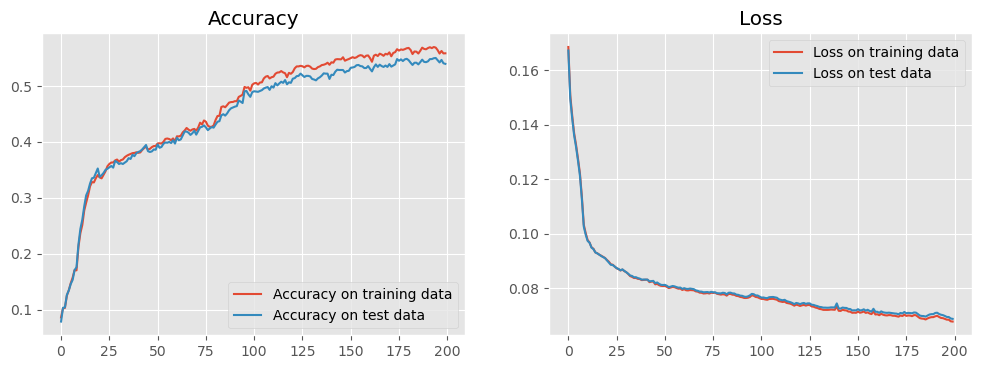

In [9]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['acc'], label='Accuracy on training data')
plt.plot(history['val_acc'], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Loss on training data')
plt.plot(history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

### 3. Make predictions

After training, we can use `model.predict` to make predictions:

In [10]:
# make predictions
pred_labels = model.predict(test_images)
print('Number of test images: %d' % test_images.shape[0])
print('Number of correct predictions: %d' % 
      np.where(np.argmax(pred_labels, axis=1) == np.argmax(test_labels, axis=1))[0].size)

Number of test images: 2000
Number of correct predictions: 1079


---

## Exercises

* **Easy**: Use shared-memory multiprocessing such as `multiprocessing.Pool` to boost training performance. Multiprocessing cannot be applied to the epoch or the mini-batch loop (because they are sequential), but can be applied to the data loop (within the mini-batch loop).

* **Medium**: Add the dropout rate as a property of `Layer`. Randomly select neurons based on this rate and drop them out by zeroing their values in both forward and backward propagations. 

* **Hard**: Implement the Adam optimiser ([original paper](https://arxiv.org/pdf/1412.6980.pdf)).